In [2]:
import pandas as pd
import pathlib
import psutil
import pickle
import numpy as np
import os
import gc
    

from tqdm.auto import tqdm
from typing import List
from datetime import datetime 

import matplotlib.pyplot as plt

from ml_utils import vimba_level, vimba_up_level, book_depth, weighted_midprice, spread, count_trades

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
MD_PATH = pathlib.Path(r"C:\Users\Xiaomi\Desktop\cmf new bot\New folder\md2")

In [5]:
bbos = pd.read_parquet(MD_PATH / 'bbo_train.parquet')
trades = pd.read_parquet(MD_PATH / 'trades_train.parquet')
lobs = pd.read_parquet(MD_PATH / 'book_train.parquet')

target = pd.read_parquet(MD_PATH / 'target_train.parquet')

In [6]:
def calc_my_features(
    bbos: pd.DataFrame,
    lobs: pd.DataFrame,
    trades: pd.DataFrame
                 ) -> pd.DataFrame:
        
        spreads_df = spread(lobs)

        w_midprice_df = weighted_midprice(lobs)

        trades_up_1_sec_df = count_trades(trades, up_second=0.5)
        #trades_up_3_sec_df = count_trades(trades, up_second=3)
        #trades_up_10_sec_df = count_trades(trades, up_second=10)

        vimba_up_3_level_df = vimba_up_level(lobs, up_level=3)
        vimba_up_5_level_df = vimba_up_level(lobs, up_level=5)
        vimba_up_10_level_df = vimba_up_level(lobs, up_level=9)

        vimba_at_levels_df = vimba_level(lobs, levels=[0, 1, 2, 3])

        bd_diff_np = book_depth(lobs, size=15, side='ask').values - book_depth(lobs, size=15, side='bid').values
        bd_diff_df = pd.DataFrame({'book_depth_diff_15_btc': bd_diff_np}, index=lobs.index)
        
        return pd.concat([
            spreads_df,
            w_midprice_df,
            trades_up_1_sec_df,
            #trades_up_3_sec_df,
            #trades_up_10_sec_df,
            vimba_up_3_level_df,
            vimba_up_5_level_df,
            vimba_up_10_level_df,
            vimba_at_levels_df,
            bd_diff_df
        ], axis=1).asof(bbos.index)

In [7]:
features_df = calc_my_features(bbos=bbos, lobs=lobs, trades=trades)

In [11]:
features_df = features_df.iloc[1:]

In [12]:
features_df.head(100)

,spread,weighted_midprice,counts_per_0.5_seconds,vimba_up_3,vimba_up_5,vimba_up_9,vimba_at_0,vimba_at_1,vimba_at_2,vimba_at_3,book_depth_diff_15_btc
local_ts,,,,,,,,,,,
1699420538500000000,0.10000,35344.92060,8.00000,0.20910,0.20851,0.16559,0.20604,0.01266,0.58757,0.11679,4.60000
1699420538700000000,0.10000,35344.92060,8.00000,0.20910,0.20851,0.16559,0.20604,0.01266,0.58757,0.11679,4.60000
1699420538800000000,0.10000,35344.92060,8.00000,0.20910,0.20851,0.16559,0.20604,0.01266,0.58757,0.11679,4.60000
1699420538900000000,0.10000,35344.92060,8.00000,0.20910,0.20851,0.16559,0.20604,0.01266,0.58757,0.11679,4.60000
1699420539000000000,0.10000,35344.92057,0.00000,0.20374,0.19352,0.17242,0.20573,0.00637,0.29928,0.02342,4.60000
1699420539200000000,0.10000,35344.92057,0.00000,0.20374,0.19352,0.17242,0.20573,0.00637,0.29928,0.02342,4.60000
1699420539300000000,0.10000,35344.92057,0.00000,0.20374,0.19352,0.17242,0.20573,0.00637,0.29928,0.02342,4.60000
1699420539400000000,0.10000,35344.92057,0.00000,0.20374,0.19352,0.17242,0.20573,0.00637,0.29928,0.02342,4.60000
1699420539500000000,0.10000,35344.92065,22.00000,0.20425,0.19240,0.16863,0.20647,0.00637,0.29624,0.02915,3.60000


In [13]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from catboost.utils import get_gpu_device_count

In [14]:
device = 'GPU' if get_gpu_device_count() > 0 else 'CPU'

In [15]:
device

'GPU'

In [16]:
model_params = {
    'depth': 5,
    'iterations': 1200,   
    'thread_count': 13,
    'learning_rate': 0.01,
    'l2_leaf_reg': 50,

    'task_type': device,
    'eval_metric': 'R2',
    
    'use_best_model': True,
    'silent': True,
}

#### Estimate quality of model 

In [17]:
model = CatBoostRegressor(**model_params)

X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size=0.2, random_state=42, shuffle=False)

# 

model.fit(X=X_train, y=y_train, eval_set=(X_test, y_test), plot=True)

score = r2_score(y_test, model.predict(X_test))
print("best_score:", score)

ValueError: Found input variables with inconsistent numbers of samples: [8270740, 8270749]

#### Fit final model


In [13]:
model_params['use_best_model'] = False

model = CatBoostRegressor(**model_params)
model.fit(X=features_df, y=target, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because R2 is/are not implemented for GPU
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


In [14]:
model.save_model('model_baseline.cbm')

In [15]:
loaded_model = CatBoostRegressor()
loaded_model.load_model('model_baseline.cbm')

In [16]:
pd.Series(loaded_model.predict(features_df))

0          0.00319
1          0.00011
2          0.00011
3          0.00008
4          0.00008
            ...   
8270744   -0.00003
8270745   -0.00003
8270746   -0.00003
8270747   -0.00003
8270748   -0.00003
Length: 8270749, dtype: float64

In [17]:
feature_importances = model.get_feature_importance(type='PredictionValuesChange')

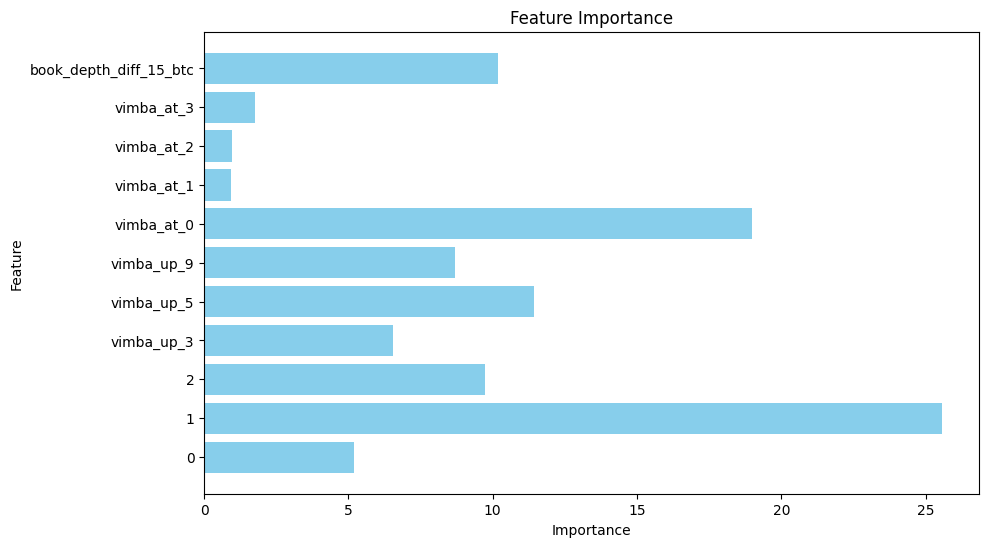

In [18]:
plt.figure(figsize=(10, 6))
plt.barh(range(len(X_train.columns)), feature_importances, color='skyblue')
plt.yticks(range(len(X_train.columns)), X_train.columns)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()